## Autonomous Driving - Car Detection with YOLO Model

## YOLO

"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real time. This algorithm "only looks once" at the image inthe sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

In [1]:
import numpy as np
import tensorflow as tf
from yad2k.utils.utils import scale_boxes
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import pandas as pd
import PIL
import keras
from PIL import ImageFont, ImageDraw, Image
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, read_classes, read_anchors, preprocess_image

%matplotlib inline

/Users/olaoluadisa/Documents/WEBDEV1/webdev/code files/codefiles/MLspecial/MLSpe_venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
/var/folders/hf/81yfsz694rx2svmh31g42bb80000gn/T/ipykernel_75862/4223346088.py:9: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  import scipy.misc


### 2.1 - Model Details

#### Inputs and outputs
- The **input** is a batch of images, and each image has the shape (608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

#### Anchor Boxes
* Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that represent the different classes.  5 anchor boxes were chosen for you (to cover the 80 classes), and stored in the file './model_data/yolo_anchors.txt'
* The dimension of the encoding tensor of the second to last dimension based on the anchor boxes is $(m, n_H,n_W,anchors,classes)$.
* The YOLO architecture is: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).  


#### Encoding
Let's look in greater detail at what this encoding represents. 

<img src="nb_images/architecture.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 1 </u></b>: Encoding architecture for YOLO<br> </center></caption>

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since you're using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, you'll flatten the last two dimensions of the shape (19, 19, 5, 85) encoding, so the output of the Deep CNN is (19, 19, 425).

<img src="nb_images/flatten.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: Flattening the last two last dimensions<br> </center></caption>

#### Class score

Now, for each box (of each cell) you'll compute the following element-wise product and extract a probability that the box contains a certain class.  
The class score is $score_{c,i} = p_{c} \times c_{i}$: the probability that there is an object $p_{c}$ times the probability that the object is a certain class $c_{i}$.

<img src="nb_images/probability_extraction.png" style="width:700px;height:400;">
<caption><center> <u><b>Figure 4</u></b>: Find the class detected by each box<br> </center></caption>

##### Example of figure 4
* In figure 4, let's say for box 1 (cell 1), the probability that an object exists is $p_{1}=0.60$.  So there's a 60% chance that an object exists in box 1 (cell 1).  
* The probability that the object is the class "category 3 (a car)" is $c_{3}=0.73$.  
* The score for box 1 and for category "3" is $score_{1,3}=0.60 \times 0.73 = 0.44$.  
* Let's say you calculate the score for all 80 classes in box 1, and find that the score for the car class (class 3) is the maximum.  So you'll assign the score 0.44 and class "3" to this box "1".

#### Visualizing classes
Here's one way to visualize what YOLO is predicting on an image:

- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across the 80 classes, one maximum for each of the 5 anchor boxes).
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture: 

<img src="nb_images/proba_map.png" style="width:300px;height:300;">
<caption><center> <u><b>Figure 5</u></b>: Each one of the 19x19 grid cells is colored according to which class has the largest predicted probability in that cell.<br> </center></caption>

Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm. 

#### Visualizing bounding boxes
Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  

<img src="nb_images/anchor_map.png" style="width:200px;height:200;">
<caption><center> <u><b>Figure 6</u></b>: Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. <br> </center></caption>

#### Non-Max suppression
In the figure above, the only boxes plotted are ones for which the model had assigned a high probability, but this is still too many boxes. You'd like to reduce the algorithm's output to a much smaller number of detected objects.  

To do so, you'll use **non-max suppression**. Specifically, you'll carry out these steps: 
- Get rid of boxes with a low score. Meaning, the box is not very confident about detecting a class, either due to the low probability of any object, or low probability of this particular class.
- Select only one box when several boxes overlap with each other and detect the same object.

In [2]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    

    # Step 1: Compute box scores = P(object) * P(class_i) for each class
    box_scores = box_confidence * box_class_probs    # shape: (19, 19, 5, 80)
    
    # Step 2: Find the best class for each box + its score
    box_classes = tf.math.argmax(box_scores, axis=-1)          # shape: (19, 19, 5)
    box_class_scores = tf.math.reduce_max(box_scores, axis=-1) # shape: (19, 19, 5)
    
    # Step 3: Create mask of boxes to keep (score ≥ threshold)
    filtering_mask = box_class_scores >= threshold    # shape: (19, 19, 5) boolean
    
    # Step 4: Apply the mask using tf.boolean_mask
    scores = tf.boolean_mask(box_class_scores, filtering_mask)   # shape: (None,)
    boxes  = tf.boolean_mask(boxes, filtering_mask)               # shape: (None, 4)
    classes = tf.boolean_mask(box_classes, filtering_mask)        # shape: (None,)

    
    return scores, boxes, classes

**Note** In the test for `yolo_filter_boxes` below, you're using random numbers to test the function.  In real data, the `box_class_probs` would contain non-zero values between 0 and 1 for the probabilities.  The box coordinates in `boxes` would also be chosen so that lengths and heights are non-negative.

In [3]:
tf.random.set_seed(10)
box_confidence = tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
box_class_probs = tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = 0.5)

print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

scores[2] = 9.270486
boxes[2] = [ 4.6399336  3.2303846  4.431282  -2.202031 ]
classes[2] = 8
scores.shape = (1789,)
boxes.shape = (1789, 4)
classes.shape = (1789,)


<a name='2-3'></a>
### 2.3 - Non-max Suppression

Even after filtering by thresholding over the class scores, you still end up with a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS). 

<img src="nb_images/non-max-suppression.png" style="width:500px;height:400;">
<caption><center> <u> <b>Figure 7</b> </u>: In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probability) of the 3 boxes. <br> </center></caption>

Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.
<img src="nb_images/iou.png" style="width:500px;height:400;">
<caption><center> <u> <b>Figure 8</b> </u>: Definition of "Intersection over Union". <br> </center></caption>



In [4]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """


    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2


    # Step 1: Calculate the (x, y) coordinates of the intersection rectangle
    xi1 = max(box1_x1, box2_x1)          # rightmost of the left edges
    yi1 = max(box1_y1, box2_y1)          # lowest of the top edges
    xi2 = min(box1_x2, box2_x2)          # leftmost of the right edges
    yi2 = min(box1_y2, box2_y2)          # highest of the bottom edges

    # Step 2: Compute width and height of intersection (will be ≤ 0 if no overlap)
    inter_width  = xi2 - xi1
    inter_height = yi2 - yi1
    
    # Intersection area — clamp to zero if negative (no overlap or just touching)
    inter_area = max(inter_width, 0) * max(inter_height, 0)

    # Step 3: Compute area of each box
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)

    # Step 4: Union area
    union_area = box1_area + box2_area - inter_area

    # Step 5: IoU
    iou = inter_area / union_area if union_area > 0 else 0.0

    
    return iou

In [5]:

## Test 
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4)

print("iou for intersecting boxes = " + str(iou(box1, box2)))

iou for intersecting boxes = 0.14285714285714285


### YOLO Non-max Suppression

You are now ready to implement non-max suppression. The key steps are as follows:

1. **Select the box with the highest score.**
2. **Compute the overlap** of this box with all other boxes of the same class. Remove any boxes that significantly overlap (IoU >= `iou_threshold`).
3. **Repeat** the process: go back to step 1 and iterate until no remaining boxes have a score lower than the currently selected box.

This process effectively eliminates boxes that overlap significantly with the selected boxes, leaving only the "best" candidates.

For implementation, consider using a divide-and-conquer approach:

* **Divide** all the boxes by class.
* Apply non-max suppression for each class individually.
* Finally, **merge** the results from each class into a single set of boxes.

In [6]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None, ), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    boxes = tf.cast(boxes, dtype=tf.float32)
    scores = tf.cast(scores, dtype=tf.float32)

    nms_indices = []
    classes_labels = tf.unique(classes)[0] # Get unique classes
    
    for label in classes_labels:
        filtering_mask = classes == label
    

        # Get boxes and scores only for this class
        boxes_label  = tf.boolean_mask(boxes, filtering_mask)
        scores_label = tf.boolean_mask(scores, filtering_mask)
        
        if tf.shape(scores_label)[0] > 0:  # if there are boxes of this class
            
            # Apply non-max suppression for this class
            nms_indices_label = tf.image.non_max_suppression(
                boxes=boxes_label,
                scores=scores_label,
                max_output_size=max_boxes,         # per class we allow up to max_boxes
                iou_threshold=iou_threshold
            )
            
            # Get the original indices (before per-class masking)
            selected_indices = tf.squeeze(tf.where(filtering_mask), axis=1)
            
            # Map NMS local indices back to global/original indices
            nms_indices.append(tf.gather(selected_indices, nms_indices_label))

    # If we have any kept indices → concatenate them
    if nms_indices:
        nms_indices = tf.concat(nms_indices, axis=0)
    else:
        nms_indices = tf.constant([], dtype=tf.int64)

    # Gather the final selected predictions using the global indices
    scores  = tf.gather(scores, nms_indices)
    boxes   = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    
    
    # Sort by scores and return the top max_boxes
    sort_order = tf.argsort(scores, direction='DESCENDING').numpy()
    scores = tf.gather(scores, sort_order[0:max_boxes])
    boxes = tf.gather(boxes, sort_order[0:max_boxes])
    classes = tf.gather(classes, sort_order[0:max_boxes])

    return scores, boxes, classes

In [7]:
scores = np.array([0.855, 0.828])
boxes = np.array([[0.45, 0.2,  1.01, 2.6], [0.42, 0.15, 1.7, 1.01]])
classes = np.array([0, 1])

scores2, boxes2, classes2 = yolo_non_max_suppression(scores, boxes, classes, iou_threshold = 0.9)
print(f"scores:  \t{scores2.numpy()}")
print(f"boxes:  \t{boxes2.numpy()}")     
print(f"classes:\t{classes2.numpy()}")

scores:  	[0.855 0.828]
boxes:  	[[0.45 0.2  1.01 2.6 ]
 [0.42 0.15 1.7  1.01]]
classes:	[0 1]


### Wrapping Up the Filtering

It's time to implement a function taking the output of the deep CNN (the 19x19x5x85 dimensional encoding) and filtering through all the boxes using the functions you've just implemented. 

In [8]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

In [9]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    # Step 1: Retrieve the four output tensors from the YOLO model
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs

    # Step 2: Convert (x_center, y_center, width, height) → (x1, y1, x2, y2) corner format
    # This is needed because yolo_filter_boxes expects corner coordinates
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Step 3: Filter boxes using objectness * class probability threshold
    scores, boxes, classes = yolo_filter_boxes(
        boxes, 
        box_confidence, 
        box_class_probs, 
        threshold=score_threshold
    )

    # Step 4: Rescale boxes from 608×608 grid back to the original image size
    # (e.g. from 608→720 in height, 608→1280 in width)
    boxes = scale_boxes(boxes, image_shape)

    # Step 5: Apply Non-Max Suppression to remove overlapping boxes
    scores, boxes, classes = yolo_non_max_suppression(
        scores, 
        boxes, 
        classes, 
        max_boxes=max_boxes, 
        iou_threshold=iou_threshold
    )
    
    return scores, boxes, classes

In [10]:
tf.random.set_seed(10)
yolo_outputs = (tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
scores, boxes, classes = yolo_eval(yolo_outputs)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

scores[2] = 171.60194
boxes[2] = [-1240.3483 -3212.5881  -645.78    2024.3052]
classes[2] = 16
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


##  Test YOLO Pre-trained Model on Images

In this section, you are going to use a pre-trained model and test it on the car detection dataset. 

Defining Classes, Anchors and Image Shape

You're trying to detect 80 classes, and are using 5 anchor boxes. The information on the 80 classes and 5 boxes is gathered in two files: "coco_classes.txt" and "yolo_anchors.txt". You'll read class names and anchors from text files. The car detection dataset has 720x1280 images, which are pre-processed into 608x608 images.

Loading a Pre-trained Model

Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounding boxes for a large range of target classes. You are going to load an existing pre-trained Keras YOLO model stored in "yolo.h5". These weights come from the official YOLO website, and were converted using a function written by Allan Zelener.  Technically, these are the parameters from the "YOLOv2" model, but are simply referred to as "YOLO" in this notebook.

In [11]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

In [12]:
yolo_model = yolo_model = keras.layers.TFSMLayer(
    "model_data/", 
    call_endpoint="serving_default"
)

### Run the YOLO on an Image

Let the fun begin! You will create a graph that can be summarized as follows:

`yolo_model.input` is given to `yolo_model`. The model is used to compute the output `yolo_model.output`
`yolo_model.output` is processed by `yolo_head`. It gives you `yolo_outputs`
`yolo_outputs` goes through a filtering function, `yolo_eval`. It outputs your predictions: `out_scores`, `out_boxes`, `out_classes`.

In [13]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image("images_yolo/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)  #Returns a dictionary, but, we need a tensor
    features = yolo_model_outputs['conv2d_22']   # ← adjust key name if needed!
    yolo_outputs = yolo_head(features, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 10 boxes for images/test.jpg
car (366, 299) (745, 648)
car (762, 282) (942, 412)
car (159, 303) (346, 440)
car (947, 324) (1280, 704)
car (705, 279) (786, 351)
bus (5, 267) (220, 407)
car (925, 285) (1045, 374)
car (336, 296) (377, 335)
car (965, 273) (1023, 292)
traffic light (681, 195) (692, 215)


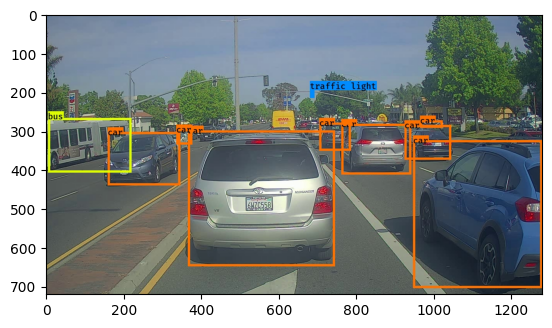

In [15]:
out_scores, out_boxes, out_classes = predict("test.jpg")


## Summary for YOLO

- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output. 
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers. 
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture. 
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and 80 is the number of classes we'd like to detect
- You then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output. 